# Building RNN with Pytorch

Dans ce TD, nous allons construire un RNN from scratch avec Pytorch, en suivant les étapes suivantes:
1. Sur un problème linéaire, nous allons utiliser les torch optimizers pour trouver le paramètre de régression idéal
2. Sur un problème non-linéaire, nous allons construire un multi-layers perceptron
3. Sur un problème de texte, nous allons construire un modèle RNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

## Optimizers

### Données example
Nous allons construire des données $y = \beta^* X + b$


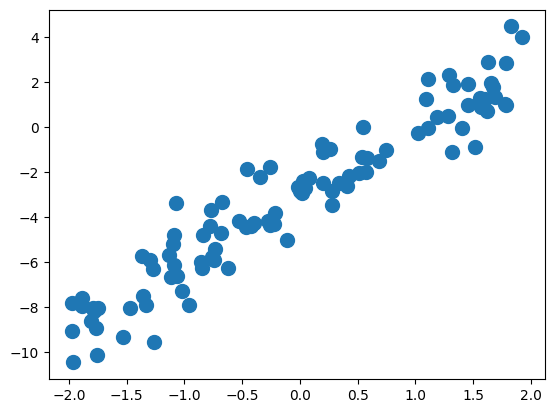

In [2]:
n = 100

a_star = 3.
b_star = -3.
noise_std = 1

x = (np.random.rand(n, 1) - 0.5) * 4
noise = np.random.normal(0, noise_std, (n, 1))
y = a_star * x + b_star + noise

x = torch.tensor(x, dtype=torch.float32)

xvec = x
plt.plot(x, y, 'o', markersize=10)

### Constuire l'optimizer

- Avec torch.nn.Parameter(), créer le paramètre beta qui sera optimisé. Les predictions du modèle sont égales à $\beta \times X$ 
- Avec torch.nn.MSELoss, déclarer la loss entre les prédictions et le résultat réel. loss.backward() pour mettre à jour les gradients
- Avec torch.optim.Adam, déclarer un optimizer
- Construisez la boucle qui, pour n_epochs, va reset les gradients, calculer la loss, mettre à jour les gradients et faire un pas pour optimiser beta

In [3]:
y = torch.tensor(y, dtype=torch.float32)

n_epochs = 1000

l_rates = 0.01

beta = torch.nn.Parameter(torch.randn(1, 1, requires_grad=True))

criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam([beta], lr=l_rates)

for epoch in range(n_epochs):
    optimizer.zero_grad()

    predictions = beta * x

    loss = criterion(predictions, y)

    loss.backward()

    optimizer.step()

    if epoch % 100 == 0:
        print(f'Époque {epoch}: Loss = {loss.item()}')

Époque 0: Loss = 33.46714782714844
Époque 100: Loss = 24.013757705688477
Époque 200: Loss = 17.806049346923828
Époque 300: Loss = 14.038287162780762
Époque 400: Loss = 11.943450927734375
Époque 500: Loss = 10.889640808105469
Époque 600: Loss = 10.414876937866211
Époque 700: Loss = 10.224742889404297
Époque 800: Loss = 10.157384872436523
Époque 900: Loss = 10.136344909667969


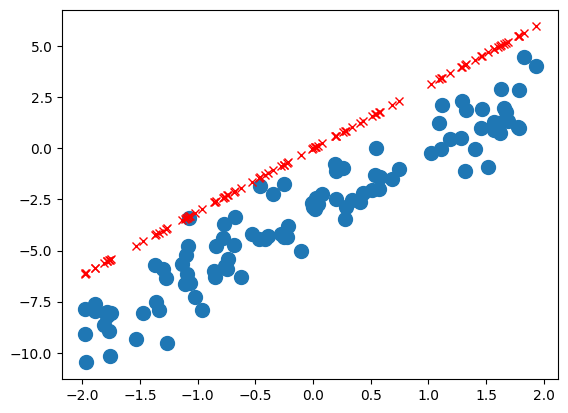

In [4]:
# Plot des predictions
plt.plot(x, y, 'o', markersize=10)
plt.plot(x, beta.item() * x, 'rx')


## Construire un multi-layer perceptron (MLP)

Ici, les données sont $y = a x^2 + b$

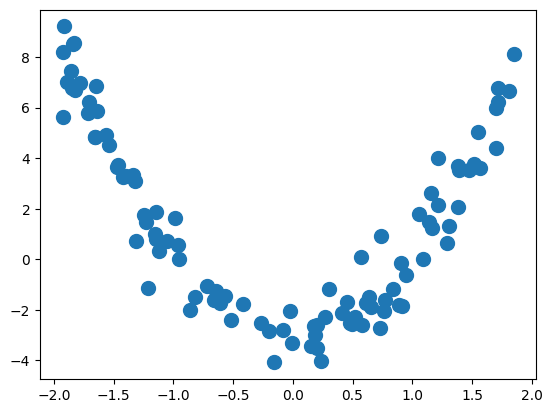

In [5]:
n = 100

a_star = 3.
b_star = -3.
noise_std = 1

x = (np.random.rand(n, 1) - 0.5) * 4
noise = np.random.normal(0, noise_std, (n, 1))
y = a_star * (x ** 2) + b_star + noise

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

xvec = x
plt.plot(x, y, 'o', markersize=10)

Nous allons construire un Pytorch modèle. Dans ce framework, on définit la fonction "forward" qui prend en argument les inputs et retourne les prédictions.

A l'aide de torch.nn.Module et de différentes layers (torch.nn.Linear, torch.nn.ReLU), terminez la classe ci-dessous pour créer un multi-layers perceptron 

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()

        hidden_size = 64
        self.layer = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(hidden_size, 1)

    def forward(self, X):
        X = self.layer(X)
        X = self.relu(X)
        X = self.layer2(X)
        
        return X

En utilisant le travail précédent, faite une cellule utilisant un torch optimizer pour optimiser le MLP 

In [7]:
l_rates = 0.01
n_epochs = 1000

model = MLP(input_size=1)

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=l_rates)

for epoch in range(n_epochs):
    optimizer.zero_grad()

    predictions = model(x)

    loss = loss_fn(predictions, y)

    loss.backward()

    optimizer.step()

    if epoch % 100 == 0:
        print(f'Époque {epoch}: Loss = {loss.item()}')

Époque 0: Loss = 15.716910362243652
Époque 100: Loss = 1.4508259296417236
Époque 200: Loss = 1.0247721672058105
Époque 300: Loss = 0.9665083289146423
Époque 400: Loss = 0.920032262802124
Époque 500: Loss = 0.8834377527236938
Époque 600: Loss = 0.8560232520103455
Époque 700: Loss = 0.8386333584785461
Époque 800: Loss = 0.8274754285812378
Époque 900: Loss = 0.8197445869445801


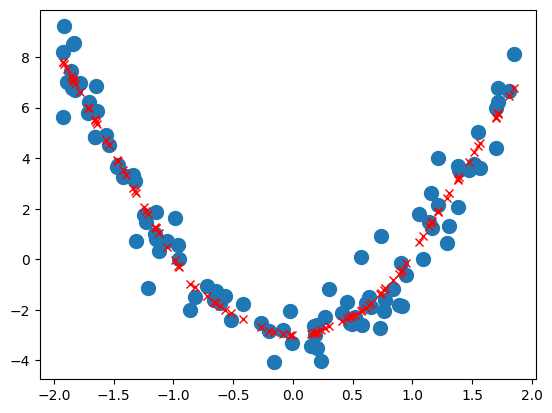

In [8]:
# Plot des predictions
plt.plot(x, y, 'o', markersize=10)
plt.plot(x, model(x).detach(), 'rx')

## Construire un Recurrent Neural Network (RNN) from scratch

### Données
 
Téléchargez [ici](https://download.pytorch.org/tutorial/data.zip) un jeu de données "nom" -> pays d'origine du nom.
Les noms de chaque pays sont dans leur fichier texte "[country].txt"

A partir de ces données, créez X la liste des noms et y le pays d'origine de chaque nom

### Aide pour générer les données

A la fin de ce code, on lit les noms et leur pays d'origine.<br>
On a une fonction randomTrainingExample, qui génère le pays d'origine et le nom (en texte), puis l'ID de ce pays et le tenseur représetant le nom. <br>

A partir de là, vous pouvez générer les données X, y comme vous voulez

In [9]:
# Code pour générer le jeu de données
# En admettant que les fichiers ont été extraits dans data/raw/names/

import math
import numpy as np
from pathlib import Path
import random
import string
import time
import unicodedata
import matplotlib.pyplot as plt

path = Path("../src/data/raw/names/")

In [10]:
def read_names(path):
    category_lines = {}
    for file in path.iterdir():
        if not file.name.endswith(".txt"):
            continue
            
        with open(file) as f:
            names = [unicodeToAscii(line.strip()) for line in f]
        
        category = file.stem
        category_lines[category] = names

    return category_lines

# Handling ASCII stuff
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [11]:
category_lines = read_names(path) # names per language
all_categories = list(category_lines.keys()) # languages
n_categories = len(all_categories) 

In [12]:
category_lines

{'Arabic': ['Khoury',
  'Nahas',
  'Daher',
  'Gerges',
  'Nazari',
  'Maalouf',
  'Gerges',
  'Naifeh',
  'Guirguis',
  'Baba',
  'Sabbagh',
  'Attia',
  'Tahan',
  'Haddad',
  'Aswad',
  'Najjar',
  'Dagher',
  'Maloof',
  'Isa',
  'Asghar',
  'Nader',
  'Gaber',
  'Abboud',
  'Maalouf',
  'Zogby',
  'Srour',
  'Bahar',
  'Mustafa',
  'Hanania',
  'Daher',
  'Tuma',
  'Nahas',
  'Saliba',
  'Shamoon',
  'Handal',
  'Baba',
  'Amari',
  'Bahar',
  'Atiyeh',
  'Said',
  'Khouri',
  'Tahan',
  'Baba',
  'Mustafa',
  'Guirguis',
  'Sleiman',
  'Seif',
  'Dagher',
  'Bahar',
  'Gaber',
  'Harb',
  'Seif',
  'Asker',
  'Nader',
  'Antar',
  'Awad',
  'Srour',
  'Shadid',
  'Hajjar',
  'Hanania',
  'Kalb',
  'Shadid',
  'Bazzi',
  'Mustafa',
  'Masih',
  'Ghanem',
  'Haddad',
  'Isa',
  'Antoun',
  'Sarraf',
  'Sleiman',
  'Dagher',
  'Najjar',
  'Malouf',
  'Nahas',
  'Naser',
  'Saliba',
  'Shamon',
  'Malouf',
  'Kalb',
  'Daher',
  'Maalouf',
  'Wasem',
  'Kanaan',
  'Naifeh',
  'Boutro

In [13]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [14]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Dixon
category = Chinese / line = Khu
category = Russian / line = Bagalin
category = Arabic / line = Safar
category = Dutch / line = Buiren
category = English / line = Ralston
category = Vietnamese / line = Quang
category = English / line = Gillett
category = English / line = Eales
category = Czech / line = Riedel


### Construire le RNN

Un Recurrent Neural Network prend, pour prédire un input X et un hidden state H.<br>
Il output une prédiction et un nouvel hidden state pour la prochaine étape.<br>
Nous allons construire un modèle:

$f(name, H_0) = (proba(\mbox{name from country 0}), proba(\mbox{name from country 1}), \dots)$

Avec $H_0$ un hidden state initial (qui sera appris).

Pour l'instant, nous allons construire un RNN linéaire.<br>
Comme pour le MLP, construisez un torch.nn.Module:
- A l'init, la classe prendra les arguments input_size, hidden_state_dim, output_size
- L'init déclare un paramètre pour l'hidden state initial $H_0$, une layer linéaire prenant (input, hidden_state) -> output_size
- Le forward fonctionnera ainsi:
    - hidden_state = $H_0$
    - For letter in name:
        - x = one-hot encode (letter)
        - output, hidden_state = linear_layer(x, hidden_state)
    - return softmax(output)


In [15]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def train(self, category_tensor, line_tensor, criterion, learning_rate=0.005):
        hidden = self.initHidden()

        self.zero_grad()

        for i in range(line_tensor.size()[0]):
            output, hidden = self(line_tensor[i], hidden)

        loss = criterion(output, category_tensor)
        loss.backward()

        for p in self.parameters():
            p.data.add_(p.grad.data, alpha=-learning_rate)

        return output, loss.item()

A l'aide de la negative log likelihood (torch.nn.NLLLoss), construisez une boucle optimisant ce modèle (optimizer, itération au sein des examples).

**Attention 1:** Ici, on n'a pas des tenseurs X, y. On va prendre les exemples 1 par 1.<br>
**Attention 2:** Si le modèle apprend les examples dans l'ordre (d'abord tous les noms arabes, puis tous les chinois, puis tous les tchèques, etc), cela changera grandement le résulat (et le modèle sera très mauvais)

In [16]:
l_rates = 0.003
n_epochs = 100000

hidden_size = 128
output_size = n_categories


model = RNN(input_size=n_letters, hidden_size=hidden_size, output_size=output_size)

criterion = torch.nn.NLLLoss()

current_loss = 0
all_losses = []

for epoch in range(1, n_epochs + 0):
    category, line, category_tensor, line_tensor = randomTrainingExample()

    output, loss = model.train(category_tensor, line_tensor, criterion, learning_rate=l_rates)

    current_loss += loss

    if epoch % 5000 == 0:
        print(f'Époque {epoch}: Loss = {loss}')
        all_losses.append(current_loss / 5000)
        current_loss = 0


Époque 5000: Loss = 2.8574776649475098
Époque 10000: Loss = 3.446690320968628
Époque 15000: Loss = 2.7704954147338867
Époque 20000: Loss = 3.225409507751465
Époque 25000: Loss = 0.44285914301872253
Époque 30000: Loss = 1.8414475917816162
Époque 35000: Loss = 3.96525239944458
Époque 40000: Loss = 0.5542450547218323
Époque 45000: Loss = 1.2202651500701904
Époque 50000: Loss = 0.6784166097640991
Époque 55000: Loss = 0.03791310638189316
Époque 60000: Loss = 1.0188654661178589
Époque 65000: Loss = 1.229013442993164
Époque 70000: Loss = 0.5062434673309326
Époque 75000: Loss = 0.049824319779872894
Époque 80000: Loss = 1.1665236949920654
Époque 85000: Loss = 0.07794451713562012
Époque 90000: Loss = 1.8508317470550537
Époque 95000: Loss = 0.7594630122184753


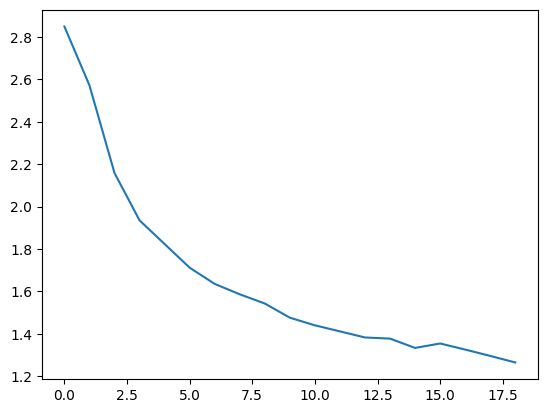

In [17]:
plt.figure()
plt.plot(all_losses)

## Utilisez les RNNs de Pytorch

Sur le même jeu de données, nous allons utiliser les RNNs déjà codés par Pytorch.<br>

### Padding

Nous voulons aussi utiliser des tenseurs X et y pour utiliser data loader pour les batchs, etc


Avec du padding, créer un tenseur X de la taille (nb_data, name_max_length, vocab_size). <br>
X[i, j, :] contient le one-hot encode de la j-ème lettre du i-ème prénom. Si le i-ème prénom a moins de j lettre, alors X[i, j, :] est un vecteur nul

In [18]:
name_max_length = 19

last_names = []

vocab = {letter: index for index, letter in enumerate("abcdefghijklmnopqrstuvwxyz', ")}

vocab2 = {letter: index for index, letter in enumerate("ABCDEFGHIJKLMNOPQRSTUVWXYZ")}

vocab_size = len(vocab)

vocab.update(vocab2)

country_to_index = {country: index for index, country in enumerate(category_lines.keys())}

for country, names in category_lines.items():
    last_names.extend([(country, name) for name in names])

nb_data = len(last_names)

X = np.zeros((nb_data, name_max_length, vocab_size), dtype=np.float32)
Y = np.zeros((nb_data, n_categories))

for i, (country, name) in enumerate(last_names):
    for j, letter in enumerate(name):
        if j >= name_max_length:
            raise ValueError(f"Name {name} is too long")
        if letter in vocab:
            X[i, j, vocab[letter]] = 1.0
        else:
            print(f"Letter {letter} not in vocab")

    Y[i][country_to_index[country]] = 1.0

X = torch.Tensor(X)
Y = torch.Tensor(Y)

Y = Y.type(torch.LongTensor)

print(X.shape)
print(Y.shape)

torch.Size([20074, 19, 29])
torch.Size([20074, 18])


### Modèle

Construisez un modèle qui:
- A l'init, déclare un hidden state initial $H_0$, un RNN (avec torch.nn.RNN)
- Au forward, passe (input, $H_0$) dans le RNN, puis applique un softmax à l'output

In [19]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)

        return out

In [20]:
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

Entraînez le modèle avec des batchs de X, y

In [21]:
input_size = vocab_size
hidden_size = 64
output_size = n_categories
batch_size = 64
learning_rate = 0.001
num_epochs = 100

In [22]:
dataset = CustomDataset(X, Y)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [23]:
model = RNNModel(input_size, hidden_size, output_size)

criterion = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
all_losses = []

for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, torch.max(labels, 1)[1])
        
        loss.backward()
        optimizer.step()
    if epoch % 5 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')
    all_losses.append(loss.item())

Epoch 0: Loss = 1.7582658529281616
Epoch 5: Loss = 2.1884002685546875
Epoch 10: Loss = 1.6095067262649536
Epoch 15: Loss = 1.6117570400238037
Epoch 20: Loss = 1.4147393703460693
Epoch 25: Loss = 1.159279227256775
Epoch 30: Loss = 1.464126706123352
Epoch 35: Loss = 1.192116618156433
Epoch 40: Loss = 0.7512012124061584
Epoch 45: Loss = 1.2834625244140625
Epoch 50: Loss = 1.130051612854004
Epoch 55: Loss = 0.9060612916946411
Epoch 60: Loss = 1.2354170083999634
Epoch 65: Loss = 0.8077175617218018
Epoch 70: Loss = 1.0415256023406982
Epoch 75: Loss = 0.5579051971435547
Epoch 80: Loss = 1.0292431116104126
Epoch 85: Loss = 1.0949780941009521
Epoch 90: Loss = 0.9746232032775879
Epoch 95: Loss = 0.8075073957443237


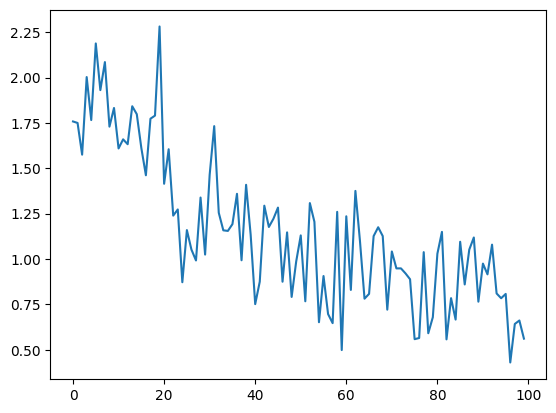

In [25]:
plt.figure()
plt.plot(all_losses)

### Amélioration du modèle

Tenter d'améliorer le modèle:
- En utilisant plusieurs layers dans le RNN
- En utilisant LSTM à la place de RNN (une autre forme de recurrent neural network, plus avancé)

(regardez la doc)

In [26]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        
        return out

In [27]:
input_size = vocab_size
hidden_size = 64
num_layers = 2
output_size = n_categories
batch_size = 64
learning_rate = 0.001
num_epochs = 100

In [28]:
dataset = CustomDataset(X, Y)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [29]:
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

criterion = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
all_losses = []

for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, torch.max(labels, 1)[1])
        
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')
        
    all_losses.append(loss.item())

Epoch 0: Loss = 1.7774970531463623
Epoch 5: Loss = 1.115361213684082
Epoch 10: Loss = 0.8864848017692566
Epoch 15: Loss = 0.5228880643844604
Epoch 20: Loss = 0.16623903810977936
Epoch 25: Loss = 0.6842705607414246
Epoch 30: Loss = 0.4937083423137665
Epoch 35: Loss = 0.5895623564720154
Epoch 40: Loss = 0.4361770749092102
Epoch 45: Loss = 0.34410515427589417
Epoch 50: Loss = 0.28455138206481934
Epoch 55: Loss = 0.19269050657749176
Epoch 60: Loss = 0.17408487200737
Epoch 65: Loss = 0.20706412196159363
Epoch 70: Loss = 0.17786899209022522
Epoch 75: Loss = 0.29753607511520386
Epoch 80: Loss = 0.204337939620018
Epoch 85: Loss = 0.32744333148002625
Epoch 90: Loss = 0.08483115583658218
Epoch 95: Loss = 0.155359148979187


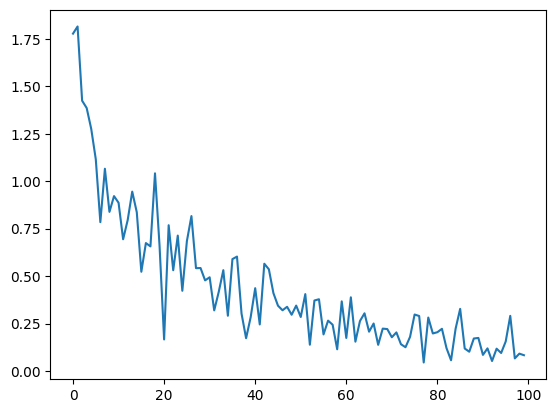

In [31]:
plt.figure()
plt.plot(all_losses)

### Embedding

On veut utiliser en embedding pour les lettres.
Le forward appliquerait l'embedding aux lettres, puis les layers RNN prendrait l'embedding comme input

Nous allons utiliser torch.nn.Embedding
**Attention**: Embedding ne prend pas les lettres one-hot encoded, mais leurs indices.
Par exemple, "abca", il lui faudrait le vecteur [0, 1, 2, 0]<br>
et non [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]]

**Expérimenter torch.nn.Embedding**<br>
Instantier "emb" une torch.nn.Embedding avec les bons paramètres (regardez la doc)
En construisant le bon tenseur X_emb,

```emb(X_emb)```

doit retourner un tenseur (qui n'a pas de sens car il n'a rien appris pour l'instant, mais les opérations se passent bien)

In [32]:
X_indices = [0, 1, 2, 0]

alphabet_size = 29
embedding_dim = 10 

emb = torch.nn.Embedding(alphabet_size, embedding_dim)

X_index_tensor = torch.tensor(X_indices, dtype=torch.long)

X_emb = emb(X_index_tensor)

print(X_emb)

tensor([[ 1.5989,  0.3529,  0.8556,  0.8627,  0.5027, -0.1187, -0.0153, -0.7204,
         -0.6280, -0.0397],
        [-0.5757, -0.7030, -0.7279,  0.4511, -0.3916,  0.3083,  0.0970,  0.3215,
         -0.9950, -0.8000],
        [-1.5164, -0.3533,  1.4265,  1.6867, -1.7230,  1.7078, -0.4716, -0.7920,
         -1.6496, -0.7214],
        [ 1.5989,  0.3529,  0.8556,  0.8627,  0.5027, -0.1187, -0.0153, -0.7204,
         -0.6280, -0.0397]], grad_fn=<EmbeddingBackward0>)


Construisez un modèle RNN, où les lettres passent par l'embedding avant d'être envoyées dans les couches de RNN.
Construisez une loop d'apprentissage

Expérimentez plusieurs valeurs pour le nombre de couche, la taille d'embedding ou les tailles d'hidden state.<br>
Quel neg log likelihood obtenez-vous ?

In [33]:
name_max_length = 19

last_names = []

vocab = {letter: index for index, letter in enumerate("abcdefghijklmnopqrstuvwxyz', ")}

vocab2 = {letter: index for index, letter in enumerate("ABCDEFGHIJKLMNOPQRSTUVWXYZ")}

vocab_size = len(vocab)

vocab.update(vocab2)

country_to_index = {country: index for index, country in enumerate(category_lines.keys())}

for country, names in category_lines.items():
    last_names.extend([(country, name) for name in names])

nb_data = len(last_names)

X = np.zeros((nb_data, name_max_length))
Y = []

for i, (country, name) in enumerate(last_names):
    for j, letter in enumerate(name):
        if j >= name_max_length:
            raise ValueError(f"Name {name} is too long")
        if letter in vocab:
            X[i, j] = vocab[letter]
        else:
            print(f"Letter {letter} not in vocab")

    Y.append(country_to_index[country])

X = torch.Tensor(X)
Y = torch.Tensor(Y)

X = X.type(torch.LongTensor)
Y = Y.type(torch.LongTensor)

print(X.shape)
print(Y.shape)

torch.Size([20074, 19])
torch.Size([20074])


In [34]:
from torch.utils.data.dataset import random_split


class RNNWithEmbedding(torch.nn.Module):
    def __init__(self, alphabet_size, embedding_dim, hidden_size, num_layers, output_size):
        super(RNNWithEmbedding, self).__init__()
        self.embedding = torch.nn.Embedding(alphabet_size, embedding_dim)
        self.rnn = torch.nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        
        return out
    
    def launch_training(self, X, Y, criterion, optimizer, batch_size=64, num_epochs=100, validation_split=0.2, shuffle_dataset=True):

        dataset = CustomDataset(X, Y)

        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_dataset)

        total_size = len(dataloader.dataset)
        train_size = int((1 - validation_split) * total_size)
        val_size = total_size - train_size

        train_dataset, val_dataset = random_split(dataloader.dataset, [train_size, val_size])

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            for inputs, labels in train_dataloader:
                optimizer.zero_grad()
                
                outputs = self(inputs)
                
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            # Evaluation
            self.eval()
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    outputs = self(inputs)
                    val_loss = criterion(outputs, labels)
                    
            self.train()
            
            if epoch % 5 == 0:
                print(f'Epoch {epoch}: Training Loss = {loss.item()} - Val Loss = {val_loss.item()}')
                
            train_losses.append(loss.item())
            val_losses.append(val_loss.item())
        
        return train_losses, val_losses

In [35]:
alphabet_size = vocab_size
output_size = n_categories
num_epochs = 100
batch_size = 64

learning_rate = 0.001
embedding_dim = 32
hidden_size = 64
num_layers = 2

In [36]:
model = RNNWithEmbedding(alphabet_size, embedding_dim, hidden_size, num_layers, output_size)

criterion = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
def print_plots(train_losses, val_losses):
    iterations = range(1, len(train_losses) + 1)

    plt.plot(iterations, train_losses, label='Train Loss')
    plt.plot(iterations, val_losses, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

Model Numéro 1: 2 couches de 64 hidden state, 32 embedding<br>

In [38]:
train_losses, val_losses = model.launch_training(X, Y, criterion, optimizer, batch_size, num_epochs)

Epoch 0: Training Loss = 1.8242348432540894 - Val Loss = 1.9154475927352905
Epoch 5: Training Loss = 1.2654954195022583 - Val Loss = 1.0732429027557373
Epoch 10: Training Loss = 0.710167646408081 - Val Loss = 0.9056183099746704
Epoch 15: Training Loss = 0.7968719005584717 - Val Loss = 0.8940032720565796
Epoch 20: Training Loss = 0.5029314756393433 - Val Loss = 0.8066267371177673
Epoch 25: Training Loss = 0.2317277491092682 - Val Loss = 0.957456648349762
Epoch 30: Training Loss = 0.4018234610557556 - Val Loss = 1.0124651193618774
Epoch 35: Training Loss = 0.23666779696941376 - Val Loss = 1.1198290586471558
Epoch 40: Training Loss = 0.32187598943710327 - Val Loss = 1.2749849557876587
Epoch 45: Training Loss = 0.13338306546211243 - Val Loss = 1.2593944072723389
Epoch 50: Training Loss = 0.374045193195343 - Val Loss = 1.4665186405181885
Epoch 55: Training Loss = 0.18781821429729462 - Val Loss = 1.4630922079086304
Epoch 60: Training Loss = 0.2780631184577942 - Val Loss = 1.4104655981063843


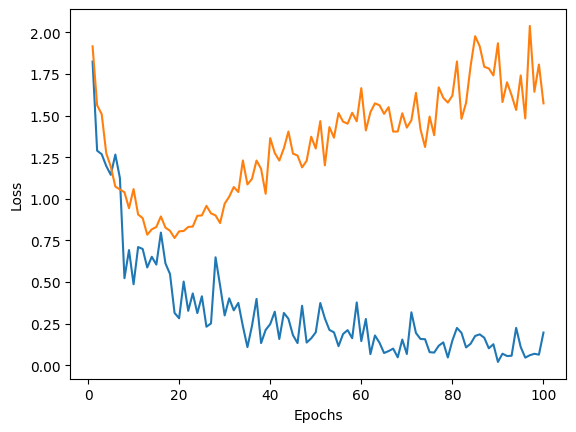

In [39]:
print_plots(train_losses, val_losses)

Model Numéro 2: 2 couches de 128 hidden state, 128 embedding<br>

In [40]:
learning_rate = 0.0005
embedding_dim = 128
hidden_size = 128
num_layers = 2

In [41]:
model = RNNWithEmbedding(alphabet_size, embedding_dim, hidden_size, num_layers, output_size)

criterion = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
train_losses, val_losses = model.launch_training(X, Y, criterion, optimizer, batch_size, num_epochs)

Epoch 0: Training Loss = 1.6821072101593018 - Val Loss = 1.7443345785140991
Epoch 5: Training Loss = 0.8566421866416931 - Val Loss = 0.7044450640678406
Epoch 10: Training Loss = 0.6144974827766418 - Val Loss = 0.6164988875389099
Epoch 15: Training Loss = 0.5814716815948486 - Val Loss = 0.5593078136444092
Epoch 20: Training Loss = 0.27517783641815186 - Val Loss = 0.6819096803665161
Epoch 25: Training Loss = 0.324228972196579 - Val Loss = 0.5829718112945557
Epoch 30: Training Loss = 0.18163228034973145 - Val Loss = 0.6929980516433716
Epoch 35: Training Loss = 0.183643639087677 - Val Loss = 0.6022170782089233
Epoch 40: Training Loss = 0.1195291206240654 - Val Loss = 0.7671457529067993
Epoch 45: Training Loss = 0.05470612645149231 - Val Loss = 0.7834610342979431
Epoch 50: Training Loss = 0.1302568018436432 - Val Loss = 0.5700914263725281
Epoch 55: Training Loss = 0.1056855320930481 - Val Loss = 0.6710271239280701
Epoch 60: Training Loss = 0.08452380448579788 - Val Loss = 0.6418382525444031

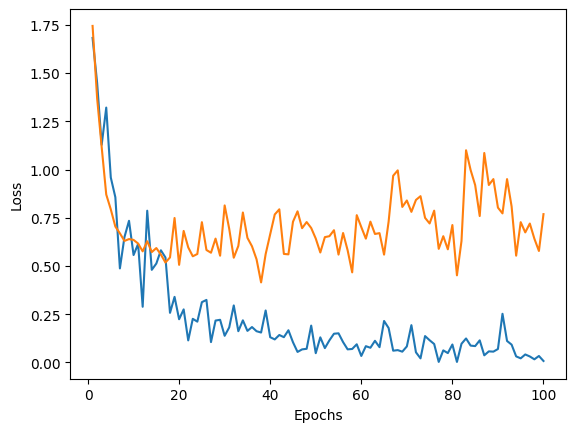

In [43]:
print_plots(train_losses, val_losses)

Model Numéro 3: 4 couches de 64 hidden state, 64 embedding with dropout<br>

In [47]:
class RNNWithEmbedding_V2(torch.nn.Module):
    def __init__(self, alphabet_size, embedding_dim, hidden_size, num_layers, output_size, dropout_prob: float = 0.2):
        super(RNNWithEmbedding_V2, self).__init__()
        self.embedding = torch.nn.Embedding(alphabet_size, embedding_dim)
        self.rnn = torch.nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.dropout = torch.nn.Dropout(dropout_prob)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        out, _ = self.rnn(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        
        return out
    
    def launch_training(self, X, Y, criterion, optimizer, batch_size=64, num_epochs=100, validation_split=0.2, shuffle_dataset=True):

        dataset = CustomDataset(X, Y)

        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_dataset)

        total_size = len(dataloader.dataset)
        train_size = int((1 - validation_split) * total_size)
        val_size = total_size - train_size

        train_dataset, val_dataset = random_split(dataloader.dataset, [train_size, val_size])

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            for inputs, labels in train_dataloader:
                optimizer.zero_grad()
                
                outputs = self(inputs)
                
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            # Evaluation
            self.eval()
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    outputs = self(inputs)
                    val_loss = criterion(outputs, labels)
                    
            self.train()
            
            if epoch % 5 == 0:
                print(f'Epoch {epoch}: Training Loss = {loss.item()} - Val Loss = {val_loss.item()}')
                
            train_losses.append(loss.item())
            val_losses.append(val_loss.item())
        
        return train_losses, val_losses

In [48]:
learning_rate = 0.0005
dr_rate = 0.2
embedding_dim = 64
hidden_size = 64
num_layers = 4

In [49]:
model = RNNWithEmbedding_V2(alphabet_size, embedding_dim, hidden_size, num_layers, output_size, dr_rate)

criterion = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [50]:
train_losses, val_losses = model.launch_training(X, Y, criterion, optimizer, batch_size, num_epochs)

Epoch 0: Training Loss = 1.6813077926635742 - Val Loss = 2.178654432296753
Epoch 5: Training Loss = 1.213136076927185 - Val Loss = 1.7349759340286255
Epoch 10: Training Loss = 1.1054030656814575 - Val Loss = 1.0597609281539917
Epoch 15: Training Loss = 0.41287127137184143 - Val Loss = 0.8392459750175476
Epoch 20: Training Loss = 0.7255374193191528 - Val Loss = 0.74928218126297
Epoch 25: Training Loss = 0.3054034113883972 - Val Loss = 0.706926703453064
Epoch 30: Training Loss = 0.7747664451599121 - Val Loss = 0.6796802282333374
Epoch 35: Training Loss = 0.7777570486068726 - Val Loss = 0.6140562295913696
Epoch 40: Training Loss = 0.43607014417648315 - Val Loss = 0.5919963121414185
Epoch 45: Training Loss = 0.3783492147922516 - Val Loss = 0.6342476606369019
Epoch 50: Training Loss = 0.31849774718284607 - Val Loss = 0.5848318934440613
Epoch 55: Training Loss = 0.5544790625572205 - Val Loss = 0.6236660480499268
Epoch 60: Training Loss = 0.21163366734981537 - Val Loss = 0.7255627512931824
Ep

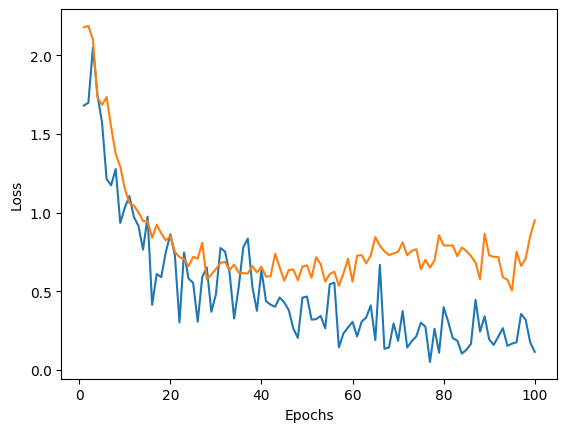

In [51]:
print_plots(train_losses, val_losses)